In [63]:
using Revise
using LinearAlgebra
using HierarchicalDA
using Distributions
using Statistics
using PDMats
using ProgressMeter
using KernelDensity
using QuadGK
using ApproxFun
using BenchmarkTools
using StaticArrays
using SpecialFunctions
using StatsFuns
using ForwardDiff
using Roots

In [2]:
using CairoMakie
using LaTeXStrings

In [3]:
Nx = 1
Ny = 1

1

In [4]:
πZ = MvNormal(zeros(Nx), PDiagMat(ones(Nx)))
πϵ = MvNormal(zeros(Nx), 0.01*PDiagMat(ones(Nx)))

DiagNormal(
dim: 1
μ: [0.0]
Σ: [0.01;;]
)


In [5]:
H = Diagonal(ones(Nx))

1×1 Diagonal{Float64, Vector{Float64}}:
 1.0

In [6]:
θgrid = collect(0.0:0.1:10.0)[2:end]
xgrid = collect(-3.0:0.1:3.0);

In [7]:
# power parameters
r_range = [ 1.0, .5, -.5, -1.0 ]; 
# shape parameters 
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ]; 
# rate parameters 
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ]; 

In [77]:
idx = 3
r = r_range[idx]
ϑ = ϑ_range[idx]
β = β_range[idx]

2.0165

In [78]:
πθ = GeneralizedGamma(r, β, ϑ)
πmultiθ = Product([πθ])

Product{Continuous, GeneralizedGamma{Float64}, Vector{GeneralizedGamma{Float64}}}(v=GeneralizedGamma{Float64}[GeneralizedGamma{Float64}(
r: -0.5
β: 2.0165
ϑ: 0.0012583
gamma_dist: Gamma{Float64}(α=2.0165, θ=1.0)
)
])

In [79]:
α = r*β - 0.5
κ = r
p = ϑ^r
q = rand(Normal())^2

Γstruct = ExtendedGamma(α, κ, p, q)

ExtendedGamma(-1.50825, -0.5, 28.19083253507958, [0.03593512652678292], [108.65153129883254], [108.65153129883254])

In [83]:
ηθ = Gamma(1.0, ϑ)

Gamma{Float64}(α=1.0, θ=0.0012583)

In [84]:
function Sθ(Γ::ExtendedGamma, θ)
    cdf!(Γ.cache, Γ, θ)
    Distributions.quantile(ηθ, abs(Γ.cache[1]))
#     return gammainvcdf(1.0, 1.0, abs(Γ.cache[1]))
end

Sθ (generic function with 1 method)

In [85]:
# @time chebΓ = Fun(x->pdf(Γstruct, x)[1], Interval(0,+Inf))
# intchebΓ = cumsum(chebΓ)

In [86]:
# Working with the multi-variate version fixes the ambiguity of providing the standard deviation in 1D 
# and the covariance in multi-dimensions.
# Build joint distribution πθXY = πθ πX|θ πY|X
function πθXY(θ, x, y)
    if typeof(θ)<:Real && typeof(x)<:Real && typeof(y) <: Real
        return pdf(πmultiθ, [θ])*pdf(MvNormal(zeros(Nx), PDiagMat([θ])), [x])*pdf(πϵ, [y] - H*[x])
    else
        return pdf(πmultiθ, θ)*pdf(MvNormal(zeros(Nx), PDiagMat(θ)), x)*pdf(πϵ, y - H*x)
    end
end

πθXY (generic function with 1 method)

In [95]:
πXY(x, y) = quadgk(θ -> πθXY(θ, x, y), 0, Inf)[1]

πXY (generic function with 1 method)

In [96]:
πY(y) = quadgk(x->πXY(x,y), -Inf, Inf)[1]

πY (generic function with 1 method)

In [97]:
πθY(θ, y) = quadgk(x -> πθXY(θ, x, y), -Inf, Inf)[1]

πθY (generic function with 1 method)

In [98]:
πθgivenXY(θ, x, y) = πθXY(θ, x, y)/πXY(x, y)

πθgivenXY (generic function with 1 method)

In [99]:
πθgivenX(θ, x) = quadgk(y->πθXY(θ, x, y), -Inf, Inf)[1]/quadgk(y->πXY(x, y), -Inf, Inf)[1]

πθgivenX (generic function with 1 method)

In [100]:
πXgivenθY(θ, x, y) = πθXY(θ, x, y)/πθY(θ, y)

πXgivenθY (generic function with 1 method)

In [101]:
πθXgivenY(θ, x, y) = πθXY(θ, x, y)/πY(y)

πθXgivenY (generic function with 1 method)

In [111]:
Γstruct

ExtendedGamma(-1.50825, -0.5, 28.19083253507958, [0.03593512652678292], [108.65153129883254], [108.65153129883254])

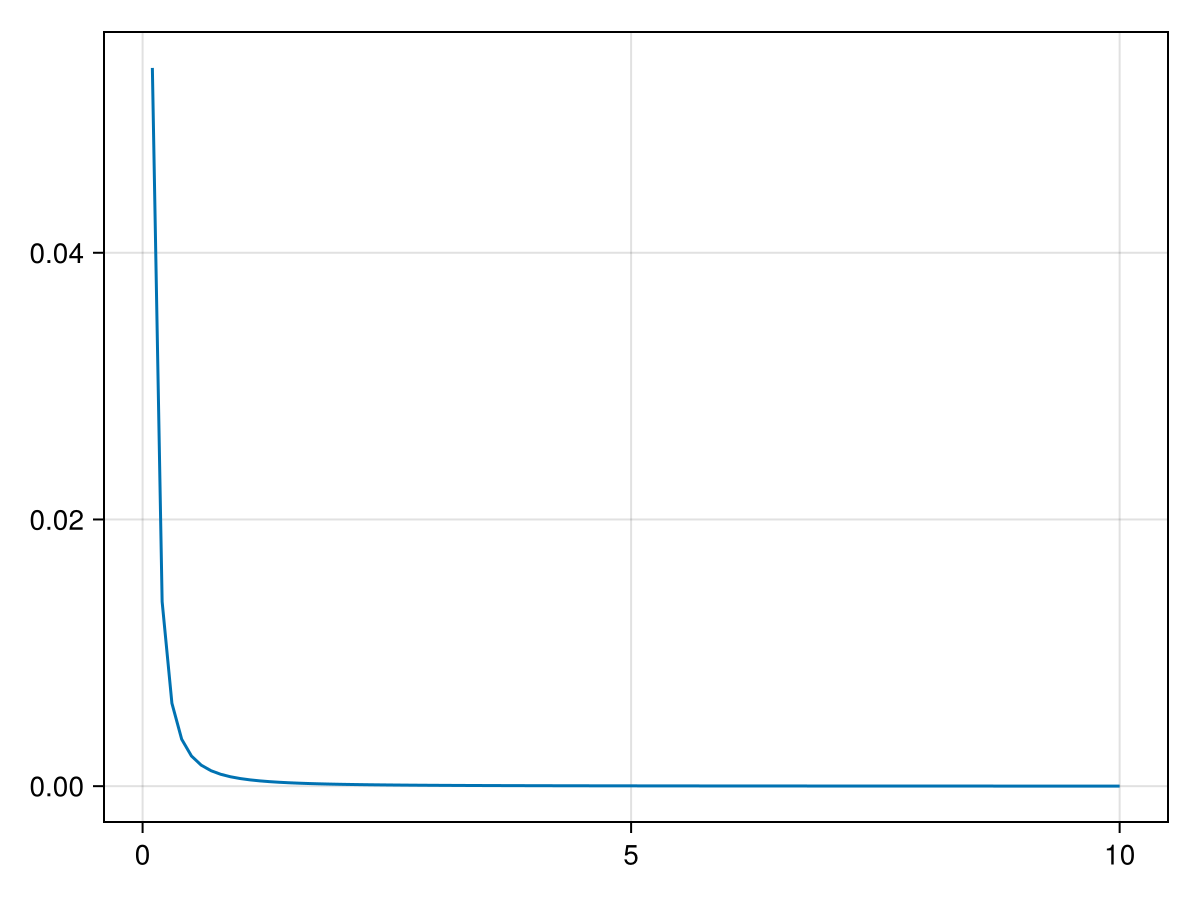

In [109]:
fig = Figure()

ax = Axis(fig[1,1])

lines!(ax, θgrid, pdf.(πθ, θgrid))
lines!(ax, θgrid, pdf.(πθ, θgrid))

    
fig

In [110]:
function TX(θ::Matrix{Float64}, X::Matrix{Float64}, Y::Matrix{Float64}, H, ystar)
    Nθ, Neθ = size(θ)
    Nx, NeX = size(X)
    Ny, NeY = size(Y)
    @assert Neθ == NeX && NeX == NeY
    Ne = Neθ
    Xa = zero(X)
    for i = 1:Ne
        Dθi = PDiagMat(θ[:,i])
        bi = (H*Dθi\H + cov(πϵ))\(Y[:,i] - ystar)
        Xa[:,i] = X[:,i] - Dθi\(H'*bi)
    end
    return Xa
end

TX (generic function with 1 method)

In [349]:
function Tθ(θ::Matrix{Float64}, X::Matrix{Float64}, Xa::Matrix{Float64})
    Nθ, Neθ = size(θ)
    Nx, NeX = size(X)
    @assert Neθ == NeX
    Ne = Neθ
    θa = zero(X)
    for i = 1:Ne
        for j=1:Nx
            θa[j,i] = exp(log(β + 0.5*X[j,i]^2) - log((β + 0.5*Xa[j,i]^2)) + log(θ[j,i]))
        end
    end
    return θa
end

Tθ (generic function with 1 method)

In [350]:
# Generate ground truth
θstar = rand(πmultiθ)
xstar = rand(πZ) ./ sqrt.(θstar)
ϵstar = rand(πϵ)
ystar = H*xstar + ϵstar

1-element Vector{Float64}:
 -0.9379254315504845

In [351]:
Niter = 10

# Sample from πθ
θ = rand(πmultiθ, Ne)
θ0 = copy(θ)

# Sample from πX|θ = N(0, D_{θ}^{-1})
X = zeros(Nx, Ne)
for i=1:Ne
    X[:,i] = rand(πZ)./sqrt.(θ[:,i])
end
X0 = copy(X)

# Sample from πY|X
Y = zero(X)
for i=1:Ne
   Y[:,i] = H*X[:,i] + rand(πϵ)
end
Y0 = copy(Y)

Xa = zero(X)
θa = zero(θ)

@showprogress for n=1:Niter
    Y = H*X + rand(πϵ, Ne)
    Xa .= TX(θ, X, Y, H, ystar)
    θa .= Tθ(θ, X, Xa)
    copy!(X, Xa)
    copy!(θ, θa)
end

In [352]:
palette = Makie.wong_colors()

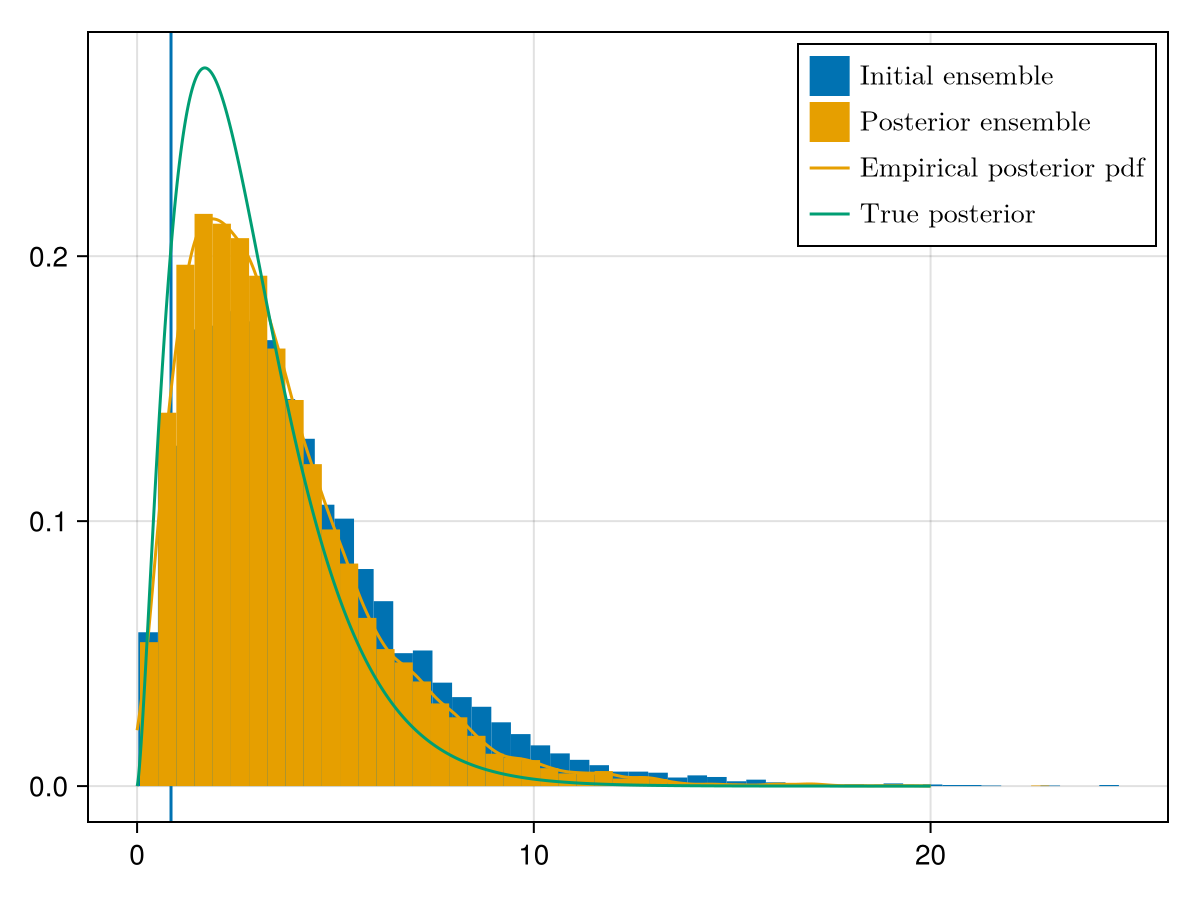

In [353]:
fig = Figure()

ax = Axis(fig[1,1])

for i=1:Nx
    kθi = KernelDensity.kde(θ[i,:])
    vlines!(ax, θstar[i])
    hist!(ax, θ0[1,:], normalization = :pdf, bins =50, label = L"\text{Initial ensemble}", color = palette[1])
    hist!(ax, θ[1,:], normalization = :pdf, bins =50, label = L"\text{Posterior ensemble}", color = palette[2])
    lines!(ax, θgrid, pdf(kθi, θgrid), label = L"\text{Empirical posterior pdf}", color = palette[2])

    lines!(ax, θgrid, πθgivenXY.(θgrid, xstar[1], ystar[1]), label = L"\text{True posterior}", color = palette[3])
end

axislegend()
fig

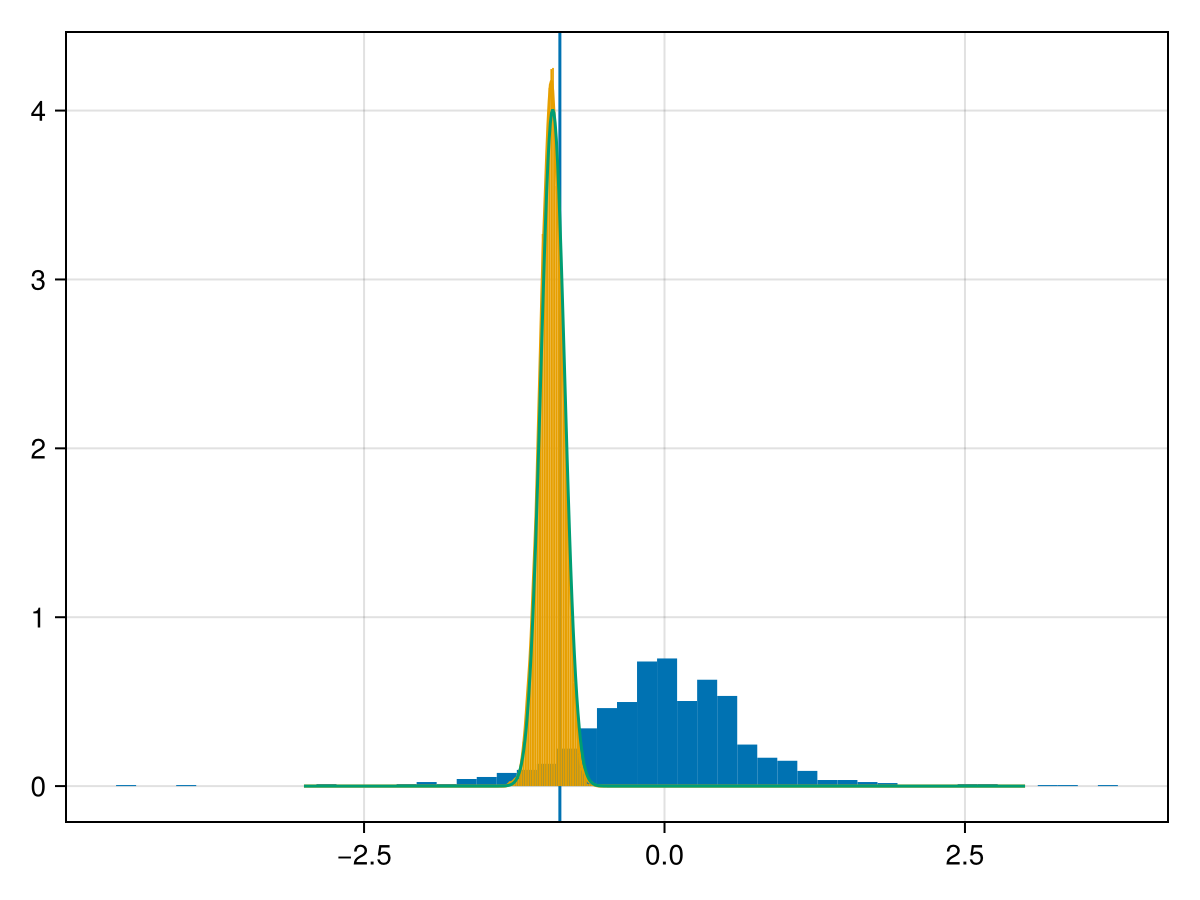

In [360]:
fig = Figure()

ax = Axis(fig[1,1])

for i=1:Nx
    kxi = KernelDensity.kde(X[i,:])
    vlines!(ax, xstar[i])
    hist!(ax, X0[1,1:1000], normalization = :pdf, bins =50, label = L"\text{Initial ensemble}", color = palette[1])
    hist!(ax, X[1,:], normalization = :pdf, bins =50, label = L"\text{Posterior ensemble}", color = palette[2])
    lines!(ax, xgrid, pdf(kxi, xgrid), label = L"\text{Empirical posterior pdf}", color = palette[2])

    lines!(ax, xgrid, πXgivenθY.(θstar[1], xgrid, ystar[1]), label = L"\text{True posterior}", color = palette[3])
end
fig

In [358]:
minimum(X0[1,1:1000])

-4.56330186455876